# HW3-A. Dataset and Dataloader for our HW3 (solution)

## About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.0 (06/03/2024)

**Requirements:**
- Python 3
- Matplotlib
- Numpy
- Pandas
- Torch
- Torchmetrics

## 0. Imports and CUDA

In addition to the libraries mentioned above, you will need the *helper_functions.py* file, which contains a few additional functions that help make this notebook simpler for you (e.g. visualisation, test cases, etc.)

Please refrain from modifying said file, but feel free to have a look at it.

In [14]:
# Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Pandas
import pandas as pd
# Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
# Helper functions (additional file)
from helper_functions import *

While not necessary, you might want to run the code for this homework using GPU. It remains possible, however, to use CPU only.

In [15]:
# Use GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## 0. Dataset Excel file generation

This section was used to generate the dataset. You may choose to uncomment code and run this cell again if you please, it is normally seeded and should not change the values in the dataset.xlsx file. Shall that happen for a reason we did not anticipate, you may simply download the dataset file again.

If you look at the function create_dataset() in the helper_functions.py file, you will recognize that we have generate 4120 values, by using a [Stochastic Process]('https://en.wikipedia.org/wiki/Stochastic_process') of some sort.
More specifically, all the entries of this time series are defined as:

$$ x(t+1) = x(t) \times (1 + a) + x(t) \times b \times n(t) $$

$$ \text{With, } x(0) = x_0, \text{ known, and }  n(t) \rightarrow N(0, 1) $$

The values, used for $ x_0 $, $ a $ and $ b $ are shown in the cell below.

In [16]:
# This function was used to generate a dataset with 4120 values in a time series.
x0 = 10
a = 5e-4
b = 5e-3
n_points = 4120
np.random.seed(27)
#times, values = create_dataset(n_points, a, b, x0)
#print(times.shape)
#print(values.shape)
#save_dataset(times, values, excel_file_path = 'dataset.xlsx')

## 1. Loading and visualizing the dataset

In this first section, we are going to load the dataset from the *'dataset.xlsx'* file and explore said dataset. Feel free to have a look at this Excel file if you need.

The cells below will define the parameters of our dataset, and load the data from the file.

In [17]:
# Load dataset from file
excel_file_path = 'dataset.xlsx'
times, values = load_dataset(excel_file_path)

In [18]:
# Visualize data in arrays
print(times.shape, values.shape)

(4120,) (4120,)


The visualization below shows the samples in the dataset. As you can see, it consists of a time series of some sort, with 4120 time entries.

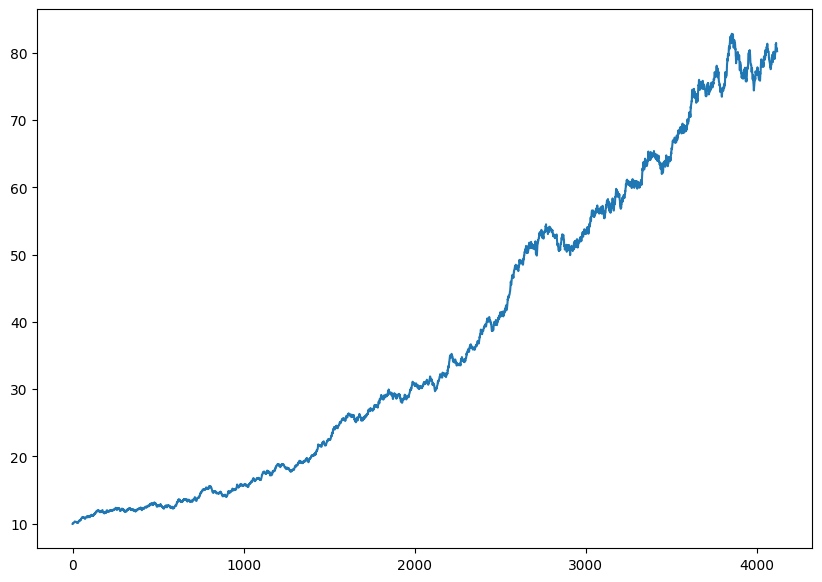

In [19]:
# Visualize the dataset
plot_dataset(times, values)

Let us pretend that this dataset, and its curve shown above, consist of values observed on the stock market over time.

Using stochastic processes to model the stock market, such as the one described in our function above, captures the essence of market volatility and randomness. Such models, incorporating randomness, allow for a range of possible outcomes, making them quite suitable for financial market simulations where uncertainty is a constant feature. In fact, one could argue that the curve above is somewhat representative of the typical curves the stock market would produce.

However, there are limitations to relying solely on stochastic processes for stock market modeling.

One significant limitation is the blatant simplification of reality of such synthetic datasets. Stochastic models are built on assumptions that may not fully capture the complexities of the real-world market. For instance, our dataset assumes that market conditions remain constant over time or follow a predictable pattern, which is rarely the case in volatile markets. More often than not, the values of the stochastic process coefficients ($ a $ and $ b $) should vary over time, instead of remaining constant.

Another signification limitation to our dataset, is that the noise level, defined by coefficient $ b $, is far below what real-life volatile markets would usually require. This large presence of noise in the data, in turn, makes it very difficult for ML models to accurately and reliably predict the market.

In this HW, we will attempt to design an AI, which 
- receives as inputs a sequence of 20 values: $ x(t), x(t+1), ..., x(t+20) $,
- and attempts to predict the next 5 values to be produced by the market, i.e. $ x(t+20+1), x(t+20+2), ..., x(t+20+5) $.

**Question 0:** This question is worth no points and serves as a disclaimer. The HW we have prepared here can not be easily transposed and reused to real-life. The quest to design an AI that is capable of predicting the market is a difficult one, and is currently seen as the holy grail of finance. The notions presented in this HW are shown to you, for educational purposes only. Shall you decide to design an AI following ideas discussed in this HW and play with the stock market, SUTD (and yours truly) cannot be held responsible for any losses incurred by the use of this AI on the stock market (seriously, don't).

**Question 1:** Knowing full well of the limitations of the synthetic dataset you are about to play with, do you think the AI we will create and whose job will be to predict the next values of the market will generalize well to real-life markets? Which principle seen in class during W1-W3 explains this generalization issue? Discuss.

<div class="alert alert-block alert-info">
<b>Answer Q1:</b> Basically, we will have a distribution mismatch between the data in the training set (this synthetic dataset) and the data in the test set (real-life market data). Stochastic processes, with stationary parameters, cannot accurately model the market, and using such data could prove difficult for generalization. The principle seen in class that will explain the poor generalization capability of the model, is the one introduced during train-test split, stressing the important of having train and test set following the same mathematical distribution. In this activity, this condition is not held and this is why our AI will probably not generalize well to real-life data. It would be equivalent to training an AI to predict appartment prices using Singaporean data, in the hopes that the AI will be able to predict prices of appartments in Sydney.
</div>

## 2. Writing a PyTorch Dataset object

Right now, we would like to write a *PyTorch Dataset* object for our Machine Learning problem.

Have a look at the incomplete code below, you will recognize that there are several None variables (called *None1*, *None2*, etc.). These variables probably need to be replaced with something else.

Your class is expected to have the following features.
- Initialization (__init__ method): The dataset initializes by reading an Excel file (dataset.xlsx) using Pandas read_excel function and stores it in the dataframe attribute.
- Length method (__len__ method): This method should return a certain information about the dataset.
- Get item method (__getitem__ method): This method is called when you index into the dataset (e.g., dataset[idx]).
- There will be an additional method, define_samples(), which will break down the data in the dataset into appropriate chunks.

**Question 2:** Study the code for the Dataset below. How many tensors will be returned when the dataset is summoned using and index *t*, by using the operation *dataset[t]* for instance? What will be the sizes of these tensors? If needed, feel free to play with the Dataset object a bit to find your answer. More importantly, what is the information contained in each of these tensors?

<div class="alert alert-block alert-info">
<b>Answer Q2: Three tensors will be returned. The three tensors are name below and their sizes are given:<br>
- Inputs is the first tensor, returned as x, and its size is n_inputs - 1. It contains $ x(t), x(t+1), ... x(t+18) $. <br>
- Outputs is the second tensor, returned as y, and its size is n_outputs. It contains $ x(t+19) $. <br>
- Mid is the third and last tensor, returned as m, and its size is 5. It contains $ x(t+20), x(t+21), ... x(t+24) $. <br>
</b> 
</div>

In [7]:
class CustomDataset(Dataset):
    def __init__(self, times, values, n_inputs, n_outputs):
        self.times = times
        self.values = values
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.define_samples()

    def define_samples(self):
        self.inputs = []
        self.outputs = []
        self.mid = []
        # Define all inputs
        for i in range(len(times) - self.n_inputs - self.n_outputs + 1):
            # Last input not included
            next_input = self.values[i:(i + self.n_inputs - 1)]
            # Output
            next_output = self.values[(i + self.n_inputs):(i + self.n_inputs + self.n_outputs)]
            # Mid is the turning point, i.e. the value of the last sample in the series of inputs
            next_mid = [self.values[i + self.n_inputs - 1]]
            self.inputs.append(next_input)
            self.outputs.append(next_output)
            self.mid.append(next_mid)
        
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        # Select samples corresponding to the different inputs
        # and outputs we have created with the define_samples() function,
        # and convert them to PyTorch tensors
        x = torch.tensor(self.inputs[idx], dtype = torch.float32)
        y = torch.tensor(self.outputs[idx], dtype = torch.float32)
        m = torch.tensor(self.mid[idx], dtype = torch.float32)
        return x, y, m

We will now create our dataset object, using the pair of values for *n_inputs = 20* and *n_outputs = 5*.

**Question 3:** For this combination of values, how many samples will the dataset contain? You may need to ask your dataset object using a certain operation. 

<div class="alert alert-block alert-info">
<b>Answer Q3: The dataset will consist of 4096 samples. This can be confirmed by using the operation print(len(pt_dataset)). Using different values for n_inputs and n_outputs will affect the number of samples.
</b> 
</div>

In [8]:
# Create our PyTorch Dataset object from the class above
n_inputs = 20
n_outputs = 5
pt_dataset = CustomDataset(times, values, n_inputs, n_outputs)

The cell below can be used to visualize the values stored in the tensor with index *idx*. Feel free to experiment with the value of idx.

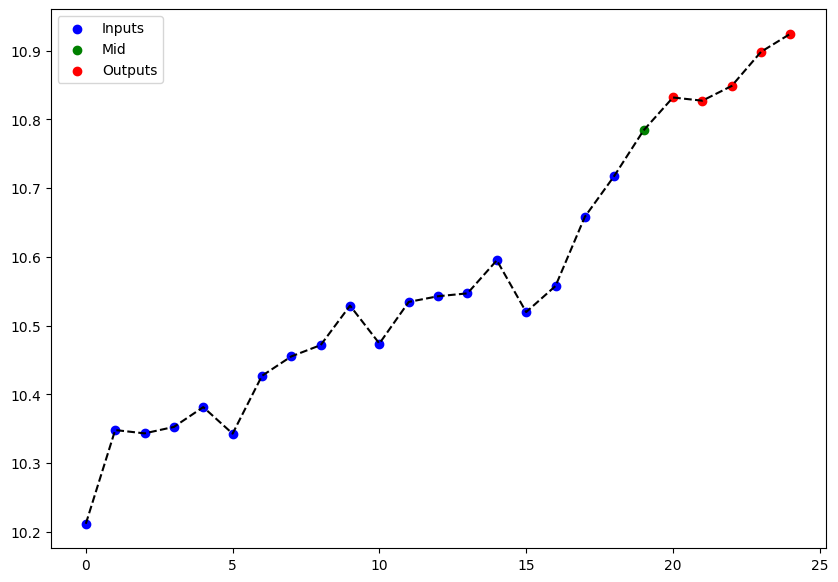

In [9]:
# Testing our dataset object and visualizing data
t = 32
inputs, outputs, mid = pt_dataset[t]
visualize_samples(inputs, mid, outputs)

## 3. Writing a Dataloader object

Our next task is now to write a PyTorch dataloader object. It will serve as a conveyor belt for our PyTorch dataset object defined in the previous section.

Its objective will be to form mini-batches of size 256.

**Question 4:** In the code below, there is a *True* value being assigned to the *shuffle* parameter of the dataloader. Until now, we have always used the *shuffle = True* configuration. Would it make sense to change it to a False for the task at hand?

<div class="alert alert-block alert-info">
<b>Answer Q4: The dataset consists of 4096 samples, and they are sorted in ascending order over time. While it might sound tempting to transform it into a False to preserve the timed order of the data, this will in fact lead to poorer results in the next notebook, as the model will be able to fit the unshuffled data, somewhat overfitting. Playing with the shuffle parameter is often a good idea, but it should probably remain set to False, unless there is a very specific reason to change it.
</b> 
</div>

In [10]:
# Define batch size
batch_size = 256

In [11]:
# Create DataLoader object
pt_dataloader = DataLoader(pt_dataset, batch_size = batch_size, shuffle = True)

**Question 5:** If you run the code below, you will get to see the value 16. What does this value 16 correspond to?

<div class="alert alert-block alert-info">
<b>Answer Q5: It simply consists of the number of mini-batches of size 256 that will be formed by the dataloader. After all, we have 4096 = 256*16.
</b> 
</div>

In [12]:
# Testing our dataloader object
print(len(pt_dataloader))

16


<div class="alert alert-block alert-info">
<b>Side note: The cell below can be used to confirm the tensor sizes (19, 5, and 1), for question 2.
</b> 
</div>

In [13]:
# Testing our dataloader object
inputs, outputs, mid = next(iter(pt_dataloader))
print(inputs.shape, outputs.shape, mid.shape)

torch.Size([256, 19]) torch.Size([256, 5]) torch.Size([256, 1])


## What is next?

Our task continues in the Notebook 3-B.